<a href="https://colab.research.google.com/github/geunsu-jo/Hands-On-ML/blob/main/textbook_practice/03_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

사이킷런에서 읽은 데이터셋은 dictionary 구조를 가지고 있다.
- 데이터셋을 설명하는 DESCR 키
- 샘플을 행, 특성(feature)를 열로 구성된 배열 data 키
- 레이블 배열이 있는 target 키

In [8]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)
print(28*28)

(70000, 784)
(70000,)
784


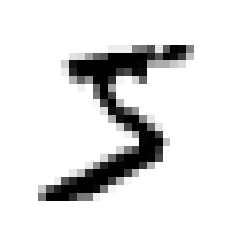

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit=X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary") # cmp="gray" 하면 높은 값을 밝게 하면서 색이 반전됨
plt.axis("off")
plt.show()

실제 레이블 확인

In [13]:
y[0]

'5'

정수로 변환

In [17]:
import numpy as np
y = y.astype(np.uint8)
y[0]

5

첫 6만개를 train으로, 나머지를 test로 나누기

In [18]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 이진 분류기 훈련
문제 단순화를 위해, 5만 분류하는 모델

In [27]:
y_train_5 = (y_train == 5) # 5이면 True, 아니면 False
y_test_5 = (y_test == 5)
y_test_5[:3]

array([False, False, False])

사이킷런의 __SGDClassifier__ 클래스를 사용해 Stochastic Gradient Descent 적용(하나의 샘플을 독립적으로 처리)

In [28]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42) 
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

- SGDClassifier(혹은 SGDRegressor)는 훈련하는데 무작위성을 가져서 Stocahstic이라 불림 (시계열 데이터엔 비적합)

In [35]:
sgd_clf.predict([some_digit])

array([ True])

## 성능 측정

### 교차검증을 사용한 방법


#### a. 단순 교차검정

In [42]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

#### b. 계층적 샘플링 교차검정

In [44]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
cross_val_score(sgd_clf, X_train, y_train_5, cv=skfolds)

array([0.9669 , 0.91625, 0.96785])

위의 과정을 수동으로 구현하면 다음과 같다

In [45]:
from sklearn.base import clone

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


- 여기서 clone은 데이터까지 복사하는 것이 아니라, 모델만 복사하는 함수다.

#### c. Accuracy 한계
지금까지의 예시에서 무조건 5가 아니라고 예측한 모델을 만들면 꽤 높은 정확도가 나온다.<br>
따라서, 정확도만 살펴볼것이 아니라 다양한 metric으로 모델을 바라볼 필요가 있다. (특히 Imbalanced data)

In [48]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator): 
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

- BaseEstimator는 하이퍼파라미터 튜닝과정이나, 교차검증을 할때 필요한 메소드를 제공해주기 때문에 필수적이로 들어간다고 함

In [51]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3 , scoring="accuracy") #cv=skfolds 넣어도됨

array([0.91125, 0.90855, 0.90915])

- 전부 5가 아니라고 예측하는, 안좋은 모델을 만들어도 90퍼이상의 성능을 보임


### 오차 행렬